# Setup

In [0]:
# Python ≥3.5 is required
import sys
sys.path.append("/Users/etienne/Library/Python/3.7/lib/python/site-packages")
assert sys.version_info >= (3, 5)

import numpy

# Common imports
import numpy as np
import os

# Scikit-Learn ≥0.20 is required
import sklearn   
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import tensorflow as tf
from tensorflow import keras

import IPython.display as display
from PIL import Image

import cv2
from tqdm import tqdm

from scipy.io import loadmat
import scipy.io as spio

from functools import partial

from google.colab import files

# Import Data 

### Import images into notebook (.tar file)

In [4]:
!wget "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar"

--2020-04-15 10:29:42--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  9.91MB/s    in 10m 50s 

2020-04-15 10:40:33 (10.3 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



In [0]:
!tar -xvf imdb_crop.tar

### Load labels with .mat file

In [0]:
# Convert .mat file to python file
matfile = spio.loadmat("/content/imdb.mat", squeeze_me=True)

In [7]:
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'imdb'])

In [8]:
# Extract "Date of Birth" and "Date of photo taken" from the .mat file
date_of_birth = matfile['imdb']['dob'][()]
photo_taken = matfile['imdb']['photo_taken'][()]
img_path = matfile['imdb']['full_path'][()]
print(img_path[:5])

['01/nm0000001_rm124825600_1899-5-10_1968.jpg'
 '01/nm0000001_rm3343756032_1899-5-10_1970.jpg'
 '01/nm0000001_rm577153792_1899-5-10_1968.jpg'
 '01/nm0000001_rm946909184_1899-5-10_1968.jpg'
 '01/nm0000001_rm980463616_1899-5-10_1968.jpg']


In [9]:
# convert Date of birth from days to years
year_of_birth = date_of_birth / 365
year_of_birth = year_of_birth.astype(int)
print(year_of_birth[:10])

[1900 1900 1900 1900 1900 1925 1925 1925 1925 1925]


In [10]:
# calculate labels (age of people) -> photo_taken - year_of_birth
labels = photo_taken - year_of_birth
labels = np.asarray(labels).astype('int32')
print(labels[:6])

[68 70 68 68 68 66]


### Load Images from directories with label paths

In [0]:
#alternative
#import pathlib
#data_dir = tf.keras.utils.get_file(origin='https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar',
                                         #fname='imdb_photos', untar=True)
#print(type(data_dir))
#data_dir = pathlib.Path(data_dir)


In [11]:
data_size = 10000
training_data = []
img_path_small = img_path[:data_size] # use only subset of data, to speed workflow
DATADIR = "/content/imdb_crop"
IMG_SIZE = 224

def create_training_data():
    for path in tqdm(img_path_small):  # iterate through each path given in .mat file

        path = os.path.join(DATADIR,path)  # create fullpath to last folder
        
        try:
            img_array = cv2.imread(path) # convert image path to array
            img_array_color = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # convert bgr image to rgb image
            new_array = cv2.resize(img_array_color, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            training_data.append([new_array])   # add image array to our training_data
        
        except Exception as e: 
                pass
            
create_training_data()
print(len(training_data))

100%|██████████| 10000/10000 [00:21<00:00, 465.28it/s]

10000


In [0]:
a = [[[1, 1, 1]], [[4, 4, 4]]] # [1, 1, 1] is one image -> representation of training_data
# Take (unpack) each image out of its own array
training_data_final = []
for img in training_data:
    training_data_final.append(img[0])

### Visualize Data

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

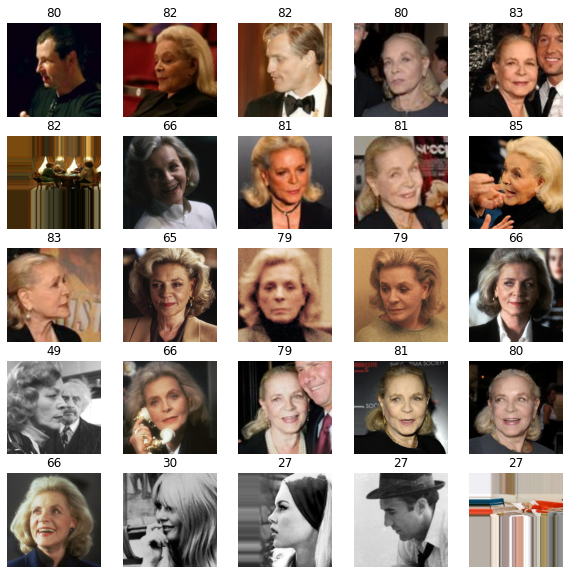

In [14]:
labels_small = labels[:data_size] 
show_batch(training_data_final[25:50], labels[25:50])

### Split Training and Test Data

In [0]:
X_train, X_valid, X_test = training_data_final[:int(data_size * 0.75)], training_data_final[int(data_size * 0.75):int(data_size * 0.90)], training_data_final[int(data_size * 0.90):]
y_train, y_valid, y_test = labels_small       [:int(data_size * 0.75)], labels_small       [int(data_size * 0.75):int(data_size * 0.90)], labels_small       [int(data_size * 0.90):]
classes = [str(x) for x in range(1,102)] # number of output neurons

In [0]:
# Combine images with labels and convert list to tf.datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)) 
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test,  y_test)) 

In [0]:
#train_dataset = tf.data.Dataset.from_tensors((X_train, y_train))
#valid_dataset = tf.data.Dataset.from_tensors((X_valid, y_valid)) 
#test_dataset  = tf.data.Dataset.from_tensors((X_test,  y_test)) 

In [0]:
#train_zip = tf.data.Dataset.zip((X_train, y_train))
#batched_dataset = dataset.batch(4, drop_remainder=True)

In [0]:
def preprocess(image, label):
    label = 100 if label > 100 else label
    label = 1 if label < 1 else label
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    #label = np.asarray(label).astype('float32')
    return final_image, label

In [20]:
print(train_dataset)
test = train_dataset.take(1).map(preprocess)

<TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.int32, tf.int32)>


In [0]:
dataset_size = len(training_data)
batch_size = 32
train_set = train_dataset.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_set  = test_dataset.map(preprocess).batch(batch_size).prefetch(1)

In [0]:
del train_dataset
del valid_dataset
del test_dataset

# Train Models

### Classification Model

In [23]:
#base_model = keras.applications.xception.Xception(weights="imagenet",
#                                                 include_top=False)
#avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
#output = keras.layers.Dense(len(classes), activation="softmax")(avg)
#model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [24]:
# freeze weights of pretrained layers at the beginning of training
#for layer in base_model.layers:
#    layer.trainable = False

#optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
#model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#              metrics=["accuracy"])
#history = model.fit(train_set,
#                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
#                    validation_data=valid_set,
#                    validation_steps=int(0.15 * dataset_size / batch_size),
#                    epochs=5)

Epoch 1/5
 71/234 [========>.....................] - ETA: 1:08 - loss: 5.7283 - accuracy: 0.0823

KeyboardInterrupt: ignored

In [0]:
# unfreeze weights of pretrained layers, also decrease lr so that weights of pretrained layers don't get destroyed
#for layer in base_model.layers:
#    layer.trainable = True

#optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001)
#model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#              metrics=["accuracy"])
#history = model.fit(train_set,
#                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
#                    validation_data=valid_set,
#                    validation_steps=int(0.15 * dataset_size / batch_size),
#                    epochs=40)

### Regression Model

In [0]:
base_model_reg = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg_reg = keras.layers.GlobalAveragePooling2D()(base_model_reg.output)
flatten = keras.layers.Flatten()(avg_reg)
hidden = keras.layers.Dense(128, activation="relu")(flatten)
output_reg = keras.layers.Dense(1)(hidden)
model_reg = keras.models.Model(inputs=base_model_reg.input, outputs=output_reg)

In [27]:
# freeze weights of pretrained layers at the beginning of training
for layer in base_model_reg.layers:
    layer.trainable = False

optimizer = keras.optimizers.RMSprop(lr=0.2, momentum=0.9, decay=0.01)
model_reg.compile(loss="mse", 
                  optimizer=optimizer,
                  metrics=["mae"])
history = model_reg.fit(train_set,
                        steps_per_epoch=int(0.75 * dataset_size / batch_size),
                        validation_data=valid_set,
                        validation_steps=int(0.15 * dataset_size / batch_size),
                        epochs=5)

Epoch 1/5
234/234 [==============================] - 22s 95ms/step - loss: 699511.0000 - mae: 101.9048 - val_loss: 77.5756 - val_mae: 7.0468
Epoch 2/5
234/234 [==============================] - 21s 91ms/step - loss: 151.2613 - mae: 9.5788 - val_loss: 76.7187 - val_mae: 7.1044
Epoch 3/5
234/234 [==============================] - 21s 91ms/step - loss: 155.0570 - mae: 9.7420 - val_loss: 76.7138 - val_mae: 7.1055
Epoch 4/5
234/234 [==============================] - 21s 91ms/step - loss: 156.3359 - mae: 9.8231 - val_loss: 76.8142 - val_mae: 7.0908
Epoch 5/5
234/234 [==============================] - 21s 91ms/step - loss: 157.7453 - mae: 9.8527 - val_loss: 77.2137 - val_mae: 7.0631


In [28]:
# unfreeze weights of pretrained layers, also decrease lr so that weights of pretrained layers don't get destroyed
for layer in base_model_reg.layers:
    layer.trainable = True

early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001)
model_reg.compile(loss="mse", optimizer=optimizer,
              metrics=["mae"])
history = model_reg.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks=[early_stopping_cb],
                    epochs=40)

Epoch 1/40
234/234 [==============================] - 114s 486ms/step - loss: 149.0166 - mae: 9.5371 - val_loss: 77.0814 - val_mae: 7.0704
Epoch 2/40
234/234 [==============================] - 88s 377ms/step - loss: 150.3671 - mae: 9.6253 - val_loss: 76.8845 - val_mae: 7.0842
Epoch 3/40
234/234 [==============================] - 88s 377ms/step - loss: 151.8952 - mae: 9.6323 - val_loss: 76.7633 - val_mae: 7.0969
Epoch 4/40
234/234 [==============================] - 88s 376ms/step - loss: 152.2433 - mae: 9.6637 - val_loss: 76.8431 - val_mae: 7.0879
Epoch 5/40
234/234 [==============================] - 88s 376ms/step - loss: 152.6251 - mae: 9.7015 - val_loss: 77.0895 - val_mae: 7.0699
Epoch 6/40
234/234 [==============================] - 88s 376ms/step - loss: 152.8789 - mae: 9.6762 - val_loss: 76.9469 - val_mae: 7.0792
Epoch 7/40
234/234 [==============================] - 88s 376ms/step - loss: 153.1348 - mae: 9.7362 - val_loss: 76.9084 - val_mae: 7.0822
Epoch 8/40
234/234 [=============

### Evaluating Model

In [29]:
model_reg.save("Regression_Transfer")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Regression_Transfer/assets


In [47]:
from sklearn.metrics import mean_squared_error

test_predictions = model_reg.predict(test_set)
final_mse = mean_squared_error(y_test, test_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

13.390842250131321


In [0]:
img_index = 6

print(test_predictions[img_index])
print(y_test[img_index])
imgplot = plt.imshow(X_test[img_index])